In [1]:
import numpy as np
import pandas as pd
import glob
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpl_patches
from scipy import stats
import warnings; warnings.filterwarnings("ignore")

In [2]:
# change with your path of data_eurec4a dir
path = '/venus/matteo/data_eurec4a/'

In [10]:
import sys; sys.path.insert(1, path + 'script')
import geometry as gm

In [16]:
minlon = -60.; maxlon = -51.
minlat = 0.; maxlat = 17.
# nlevel = 33
s = 50      # sigma gaussian filter s = 50 means 150km
path_pbindist = path + 'data/perc_dist_daily/anomalies/'
path_fbindist = path + 'data/fb_dist_daily/anomalies/'
path_pfull = path + 'data/perc_dist_daily/fullfield/'
path_full = path + 'data/fb_dist_daily/fullfield/'

In [5]:
# find and open data
wrf_files =  path + 'data/fields/data_surface_day1.nc'
ds_tot = xr.open_dataset(wrf_files, chunks='auto')

In [6]:
# select domain
mask_lon = (ds_tot.XLONG >= minlon) & (ds_tot.XLONG <= maxlon)
mask_lat = (ds_tot.XLAT >= minlat) & (ds_tot.XLAT <= maxlat)
ds = ds_tot.where(mask_lon & mask_lat, drop=True)
del ds_tot

In [7]:
# def lon lat time
lon = ds['XLONG'].values
lat = ds['XLAT'].values
time = ds['XTIME'].values.astype('<M8[s]')
# land - sea mask
lakemask = ds['LAKEMASK'][0].values
landmask = ds['LANDMASK'][0].values
seamask = 1 - lakemask - landmask
seamask[seamask==0] = np.nan
# def extended land-sea mask
seamask_nocoast = seamask.copy(); seamask_island0 = seamask.copy()
seamask_island0[:int(seamask_island0.shape[0]/2),:] = 1
seamask_island = seamask_island0.copy()
for i in range(0,5):
    for j in range(0,5):
        seamask_nocoast = np.roll(seamask, (i,j), axis=(1,0))*seamask_nocoast
        seamask_island = np.roll(seamask_island0, (-i,-j), axis=(1,0))*seamask_island
seamask_nocoast = seamask_nocoast*seamask_island
seamask = seamask_nocoast.copy()

In [11]:
# daily SST
sst_day = ds['SST'].values*seamask
# compute anomalies 
s = 50
dsst_day = np.zeros(sst_day.shape)
for t in range(0,sst_day.shape[0]):
    if t % 10 == 0:
        print(t)
    # upscale using gaussian filter
    sst_ave = gm.nan_gaussian_filter(sst_day[t],s)*seamask
    dsst_day[t] = sst_day[t] - sst_ave
# sst_day = ds['SST'].groupby('XTIME.day').mean().values*seamask - 273.15

0


In [9]:
print(np.nanmean(sst_day)-273.15)
print(np.nanmean(dsst_day))
print(np.nanstd(sst_day))
print(np.nanstd(dsst_day))

26.664819335937523
-0.0013980021048405939
0.52426255
0.24711567471059082


In [12]:
# SCATTERPLOT + DISTRIBUTION
# corr length
L = 30
nskip = int(L/3)
nt = int(1)
nbin_hist = 50
# distribution
thrsld_n = 100
perc_step = 5
nbins = int(100/perc_step) # Number of bins

In [13]:
# DEGREES OF FREEDOM
dof = np.sum(~np.isnan(dsst_day))
dof_eff = np.sum(~np.isnan(dsst_day[::nt,::nskip,::nskip]))
print(dof, dof_eff)

129622 1323


In [14]:
# punti per bin - PERC DISTRIBUTION 
# control = dsst_day.copy()
control = dsst_day[::nt,::nskip,::nskip].copy()
lower = np.percentile(control[~np.isnan(control)],0)
upper = np.percentile(control[~np.isnan(control)],5)
# cond_mean_control = np.nanmean(control[(control>=lower)&(control<upper)])
number_of_points = np.sum(~np.isnan(control[(control>=lower)&(control<upper)]))
bin_point = number_of_points
bin_point

67

In [13]:
# FIGURA PAPER

In [17]:
# dT2
pdist_dsst_day = np.loadtxt(path_pbindist + 'pdist_dsst_day.txt')
pdist_dT2_dsst_day = np.loadtxt(path_pbindist + 'pdist_dT2_dsst_day.txt')
dist_dsst_day = np.loadtxt(path_fbindist + 'dist_dsst_day.txt')
dist_dT2_dsst_day = np.loadtxt(path_fbindist + 'dist_dT2_dsst_day.txt')

t2_day = ds['T2'].values*seamask
dt2_day = np.zeros(sst_day.shape)
for t in range(0,sst_day.shape[0]):
    if t % 10 == 0:
        print(t)
    # upscale using gaussian filter
    t2_ave = gm.nan_gaussian_filter(t2_day[t],s)*seamask
    dt2_day[t] = t2_day[t] - t2_ave
del t2_day
    
from regression import slopes_r_p_dof
lin_reg_dist_dT2, r_spear, p, r_pear_dT2, pval_cann, stderr_cann_dT2 = slopes_r_p_dof(dsst_day, dt2_day, dof_eff)
print(lin_reg_dist_dT2, r_spear, p, pval_cann, r_pear_dT2, stderr_cann_dT2)

0
LinregressResult(slope=0.2585784965925655, intercept=0.003734365915535285, rvalue=0.5201109866777865, pvalue=0.0, stderr=0.001179419821454672) 0.5208505435766247 0.0 0.0 0.520110986677787 0.011674129558576914


In [18]:
##############
# dPBLH
pdist_dsst_day = np.loadtxt(path_pbindist + 'pdist_dsst_day.txt')
pdist_dPBLH_dsst_day = np.loadtxt(path_pbindist + 'pdist_dPBLH_dsst_day.txt')
pstderr_dPBLH_dsst_day = np.loadtxt(path_pbindist + 'pstderr_dPBLH_dsst_day.txt')

# read DAILY PBLH
PBLH_day = ds['PBLH'].values*seamask
dPBLH_day = np.zeros(sst_day.shape)
for t in range(0,sst_day.shape[0]):
    if t % 10 == 0:
        print(t)
    # upscale using gaussian filter
    h_ave = gm.nan_gaussian_filter(PBLH_day[t],s)*seamask
    dPBLH_day[t] = PBLH_day[t] - h_ave
del PBLH_day
    
from regression import slopes_r_p_dof
lin_reg_dist_dPBLH, r_spear, p, r_pear_dPBLH, pval_cann, stderr_cann_dPBLH = slopes_r_p_dof(dsst_day, dPBLH_day, dof_eff)
print(lin_reg_dist_dPBLH, r_spear, p, pval_cann, r_pear_dPBLH, stderr_cann_dPBLH)

0
LinregressResult(slope=39.093088135892785, intercept=-0.12828578159880766, rvalue=0.38552267052581063, pvalue=0.0, stderr=0.25988056295875805) 0.3690683930007299 0.0 0.0 0.38552267052581074 2.5723489689994556


In [19]:
##############
# dLHF
pdist_dsst_day = np.loadtxt(path_pbindist + 'pdist_dsst_day.txt')
pdist_dLHF_dsst_day = np.loadtxt(path_pbindist + 'pdist_dLHF_dsst_day.txt')
# coupling coeff for LHF_th - computed from LHF_SHF_day script
cc_th = 10.310869252317964

# READ DAILY LHF
LHF_file = path + 'data/fields/LHF_day1.nc'
ds_tmp = xr.open_dataset(LHF_file) 
LHF_day = ds_tmp['LHF'].values*seamask
dLHF_day = np.zeros(sst_day.shape)
for t in range(0,sst_day.shape[0]):
    if t % 10 == 0:
        print(t)
    # upscale using gaussian filter
    f_ave = gm.nan_gaussian_filter(LHF_day[t],s)*seamask
    dLHF_day[t] = LHF_day[t] - f_ave
del LHF_day

from regression import slopes_r_p_dof
lin_reg_dist_dLHF, r_spear, p, r_pear_dLHF, pval_cann, stderr_cann_dLHF = slopes_r_p_dof(dsst_day, dLHF_day, dof_eff)
print(lin_reg_dist_dLHF, r_spear, p, pval_cann, r_pear_dLHF, stderr_cann_dLHF)

0
LinregressResult(slope=40.709735389377855, intercept=-0.15314110613425425, rvalue=0.833354464848799, pvalue=0.0, stderr=0.07499849799499533) 0.8289439028755013 0.0 0.0 0.8333544648487994 0.7423498964197244


In [20]:
##############
# dSHF
pdist_dsst_day = np.loadtxt(path_pbindist + 'pdist_dsst_day.txt')
pdist_dSHF_dsst_day = np.loadtxt(path_pbindist + 'pdist_dSHF_dsst_day.txt')

# READ DAILY SHF
# COMPUTE DAILY SHF from hourly
SHF_file = path + 'data/fields/SHF_day1.nc'
ds_tmp = xr.open_dataset(SHF_file) 
SHF_day = ds_tmp['SHF'].values*seamask
dSHF_day = np.zeros(sst_day.shape)
for t in range(0,sst_day.shape[0]):
    if t % 10 == 0:
        print(t)
    # upscale using gaussian filter
    f_ave = gm.nan_gaussian_filter(SHF_day[t],s)*seamask
    dSHF_day[t] = SHF_day[t] - f_ave
del SHF_day

from regression import slopes_r_p_dof
lin_reg_dist_dSHF, r_spear, p, r_pear_dSHF, pval_cann, stderr_cann_dSHF = slopes_r_p_dof(dsst_day, dSHF_day, dof_eff)
print(lin_reg_dist_dSHF, r_spear, p, pval_cann, r_pear_dSHF, stderr_cann_dSHF)

0
LinregressResult(slope=9.203700640561664, intercept=-0.04668097720150957, rvalue=0.8811766282876887, pvalue=0.0, stderr=0.013716055355011055) 0.8570962613692927 0.0 0.0 0.8811766282876891 0.13576421587481813


In [21]:
##############
# dQVAPOR
pdist_dsst_day = np.loadtxt(path_pbindist + 'pdist_dsst_day.txt')
pdist_dQ2_dsst_day = np.loadtxt(path_pbindist + 'pdist_dQ2_dsst_day.txt')
pdist_dqvapor_dsst_day = np.loadtxt(path_pbindist + 'pdist_dQVAPOR_dsst_day.txt')
pstd_dQ2_dsst_day = np.loadtxt(path_pbindist + 'pstd_dQ2_dsst_day.txt')
pstd_dqvapor_dsst_day = np.loadtxt(path_pbindist + 'pstd_dQVAPOR_dsst_day.txt')
pstderr_dQ2_dsst_day = np.loadtxt(path_pbindist + 'pstderr_dQ2_dsst_day.txt')
pstderr_dqvapor_dsst_day = np.loadtxt(path_pbindist + 'pstderr_dQVAPOR_dsst_day.txt')

# 2m
q2_day = ds['Q2'].values*seamask*1000.
dq2_day = np.zeros(sst_day.shape)
for t in range(0,sst_day.shape[0]):
    if t % 10 == 0:
        print(t)
    # upscale using gaussian filter
    q2_ave = gm.nan_gaussian_filter(q2_day[t],s)*seamask
    dq2_day[t] = q2_day[t] - q2_ave
del q2_day

from regression import slopes_r_p_dof
lin_reg_dist_dq2, r_spear, p, r_pear, pval_cann, stderr_cann_dq2 = slopes_r_p_dof(dsst_day, dq2_day, dof_eff)
print(lin_reg_dist_dq2, r_spear, p, pval_cann, r_pear, stderr_cann_dq2)

# 970hPa
ds_tmp = xr.open_dataset(path + 'data/fields/QVAPOR_lev_11_25_day.nc') 
q11_day = ds_tmp['QVAPOR'][:,0,:sst_day.shape[1],:sst_day.shape[1]].values*seamask*1000.
dq11_day = np.zeros(sst_day.shape)
for t in range(0,sst_day.shape[0]):
    if t % 10 == 0:
        print(t)
    # upscale using gaussian filter
    q2_ave = gm.nan_gaussian_filter(q11_day[t],s)*seamask
    dq11_day[t] = q11_day[t] - q2_ave
del q11_day

from regression import slopes_r_p_dof
lin_reg_dist_dq11, r_spear, p, r_pear, pval_cann, stderr_cann_dq11 = slopes_r_p_dof(dsst_day, dq11_day, dof_eff)
print(lin_reg_dist_dq11, r_spear, p, pval_cann, r_pear, stderr_cann_dq11)

# 900hPa
ds_tmp = xr.open_dataset(path + 'data/fields/QVAPOR_lev_11_25_day.nc') 
q25_day = ds_tmp['QVAPOR'][:,1,:sst_day.shape[1],:sst_day.shape[1]].values*seamask*1000.
dq25_day = np.zeros(sst_day.shape)
for t in range(0,sst_day.shape[0]):
    if t % 10 == 0:
        print(t)
    # upscale using gaussian filter
    q2_ave = gm.nan_gaussian_filter(q25_day[t],s)*seamask
    dq25_day[t] = q25_day[t] - q2_ave
del q25_day

from regression import slopes_r_p_dof
lin_reg_dist_dq25, r_spear, p, r_pear, pval_cann, stderr_cann_dq25 = slopes_r_p_dof(dsst_day, dq25_day, dof_eff)
print(lin_reg_dist_dq11, r_spear, p, pval_cann, r_pear, stderr_cann_dq25)

0
LinregressResult(slope=0.14416622359905557, intercept=0.003939241790192571, rvalue=0.28706971065724807, pvalue=0.0, stderr=0.0013361792107621576) 0.2975499398612539 0.0 0.0 0.28706971065724807 0.013225764851633006
0
LinregressResult(slope=0.012217556256476433, intercept=0.003903879826295669, rvalue=0.02256772213984824, pvalue=4.435940621617551e-16, stderr=0.0015033150010073197) 0.041448929799523124 0.13155762642378943 0.4117563804533386 0.022567722139848253 0.014880107803738591
0
LinregressResult(slope=0.012217556256476433, intercept=0.003903879826295669, rvalue=0.02256772213984824, pvalue=4.435940621617551e-16, stderr=0.0015033150010073197) -0.025294757698937412 0.3575616413906484 0.038271233677976024 -0.05692807685240257 0.0754908035687451


Text(0.5, 1.0, '(e)')

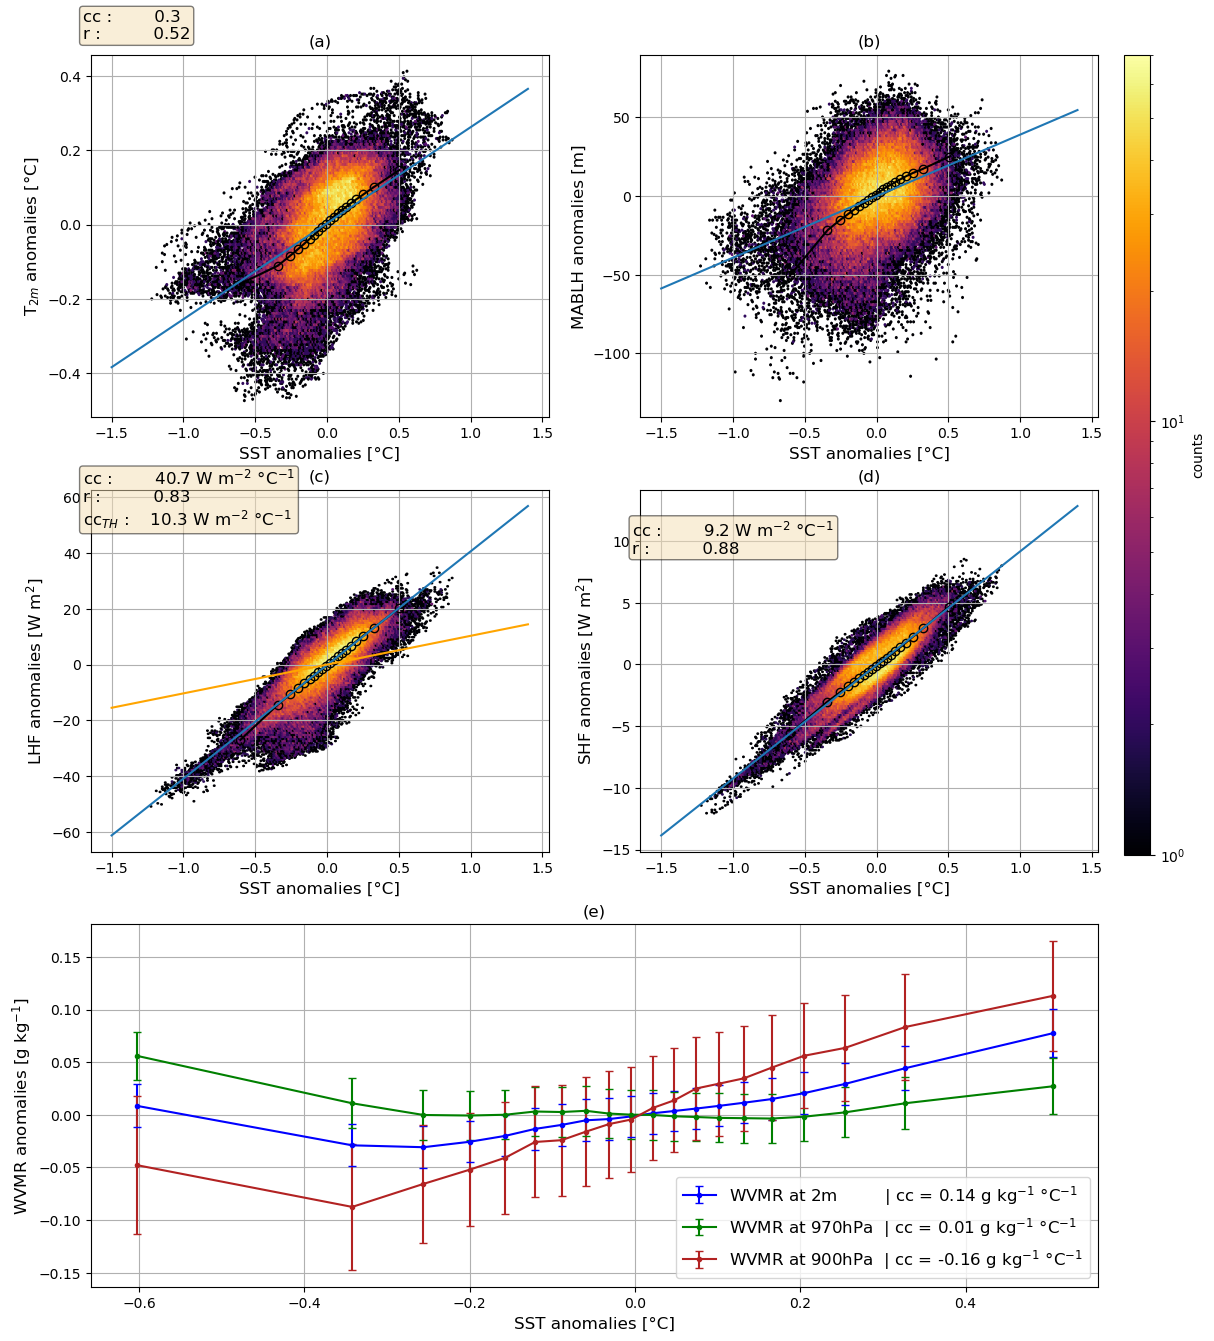

In [22]:
layout = [
    ["A", "B"],
    ["C", "D"],
    ["E", "E"]
]

fig, axd = plt.subplot_mosaic(layout, figsize=(13,16))

# -----
# dT2
# -----
x = dsst_day.copy(); y = dt2_day.copy()
ax = axd['A']
title = "(a)"
xlabel = 'SST anomalies [°C]'; ylabel = "T$_{2m}$ anomalies [°C]"
# histogram 2d
x = x[~np.isnan(x)]; y = y[~np.isnan(y)]
hb1 = ax.hexbin(x, y, mincnt=1, gridsize=200, bins='log', cmap='inferno')
# perc distribution
ax.plot(pdist_dsst_day, pdist_dT2_dsst_day, 'o-', color='k', mfc='none')
# fit
sl = lin_reg_dist_dT2.slope; intcp = lin_reg_dist_dT2.intercept 
xarr = np.arange(-1.5,1.5,0.1)
ax.plot(xarr,xarr*sl + intcp)
# empty text box with background color
props = dict(boxstyle='round,pad=0.2', facecolor='wheat', alpha=0.5)
textbox = '\n'.join(['cc :        ' + '{:0.1f}'.format(lin_reg_dist_dT2.slope), \
#                      'std err : ' + '{:0.3f}'.format(stderr_cann_dT2), \
                     'r :          ' + '{:0.2f}'.format(r_pear_dT2)])
ax.text(-1.7, 0.5, textbox, fontsize = 12, bbox=props, ha='left')
ax.grid()
ax.set_xlabel(xlabel, fontsize=12); ax.set_ylabel(ylabel, fontsize=12)
ax.set_title(title, fontsize=12)

# -----
# dPBLH
# -----
x = dsst_day.copy(); y = dPBLH_day.copy()
ax = axd['B']
title = "(b)"
xlabel = 'SST anomalies [°C]'; ylabel = "MABLH anomalies [m]"
# histogram 
x = x[~np.isnan(x)]; y = y[~np.isnan(y)]
hb = ax.hexbin(x, y, mincnt=1, gridsize=200, cmap='inferno', norm=mpl.colors.LogNorm())
# perc distribution
ax.plot(pdist_dsst_day, pdist_dPBLH_dsst_day, 'o-', color='k', mfc='none', label='PBLH')
# fit
sl = lin_reg_dist_dPBLH.slope; intcp = lin_reg_dist_dPBLH.intercept 
xarr = np.arange(-1.5,1.5,0.1)
ax.plot(xarr,xarr*sl + intcp)
# empty text box with background color
props = dict(boxstyle='round,pad=0.2', facecolor='wheat', alpha=0.5)
textbox = '\n'.join(['cc :        ' + '{:0.1f}'.format(lin_reg_dist_dPBLH.slope) + ' m °C$^{-1}$', \
#                      'std err : ' + '{:0.1f}'.format(stderr_cann_dPBLH) +  ' m °C$^{-1}$', \
                     'r :          ' + '{:0.2f}'.format(r_pear_dPBLH)])
ax.text(0.1, -500, textbox, fontsize = 12, bbox=props, ha='left')
ax.grid()
ax.set_xlabel(xlabel, fontsize=12); ax.set_ylabel(ylabel, fontsize=12)
ax.set_title(title, fontsize=12)

# -----
# dLHF
# -----
x = dsst_day.copy(); y = dLHF_day.copy()
ax = axd['C']
title = "(c)"
xlabel = 'SST anomalies [°C]'; ylabel = "LHF anomalies [W m$^{2}$]"
# histogram 2d
x = x[~np.isnan(x)]; y = y[~np.isnan(y)]
hb = ax.hexbin(x, y, mincnt=1, gridsize=200, bins='log', cmap='inferno')
# perc distribution
ax.plot(pdist_dsst_day, pdist_dLHF_dsst_day, 'o-', color='k', mfc='none', label='LHF')
# fit
sl = lin_reg_dist_dLHF.slope; intcp = lin_reg_dist_dLHF.intercept 
xarr = np.arange(-1.5,1.5,0.1)
ax.plot(xarr,xarr*sl + intcp)
# LHF TH distribution
ax.plot(xarr,xarr*cc_th, label='LHF$_{TH}$', color='orange')
# empty text box with background color
props = dict(boxstyle='round,pad=0.2', facecolor='wheat', alpha=0.5)
textbox = '\n'.join(['cc :        ' + '{:0.1f}'.format(lin_reg_dist_dLHF.slope) + ' W m$^{-2}$ °C$^{-1}$', \
#                      'std err : ' + '{:0.1f}'.format(stderr_cann_dLHF) +  ' W m$^{-2}$ °C$^{-1}$', \
                     'r :          ' + '{:0.2f}'.format(r_pear_dLHF), \
                    'cc$_{TH}$ :    ' + '{:0.1f}'.format(cc_th) + ' W m$^{-2}$ °C$^{-1}$'])
ax.text(-1.7, 50, textbox, fontsize = 12, bbox=props, ha='left')
ax.grid()
ax.set_xlabel(xlabel, fontsize=12); ax.set_ylabel(ylabel, fontsize=12)
ax.set_title(title, fontsize=12)

# -----
# dSHF
# -----
x = dsst_day.copy(); y = dSHF_day.copy()
ax = axd['D']
title = "(d)"
xlabel = 'SST anomalies [°C]'; ylabel = "SHF anomalies [W m$^{2}$]"
# histogram 2d
x = x[~np.isnan(x)]; y = y[~np.isnan(y)]
hb = ax.hexbin(x, y, mincnt=1, gridsize=200, bins='log', cmap='inferno')
# perc distribution
ax.plot(pdist_dsst_day, pdist_dSHF_dsst_day, 'o-', color='k', mfc='none', label='SHF')
# fit
sl = lin_reg_dist_dSHF.slope; intcp = lin_reg_dist_dSHF.intercept 
xarr = np.arange(-1.5,1.5,0.1)
ax.plot(xarr,xarr*sl + intcp)
# empty text box with background color
props = dict(boxstyle='round,pad=0.2', facecolor='wheat', alpha=0.5)
textbox = '\n'.join(['cc :        ' + '{:0.1f}'.format(lin_reg_dist_dSHF.slope) + ' W m$^{-2}$ °C$^{-1}$', \
#                      'std err : ' + '{:0.2f}'.format(stderr_cann_dSHF) +  ' W m$^{-2}$ °C$^{-1}$', \
                     'r :          ' + '{:0.2f}'.format(r_pear_dSHF)])
ax.text(-1.7, 9, textbox, fontsize = 12, bbox=props, ha='left')
ax.grid()
ax.set_xlabel(xlabel, fontsize=12); ax.set_ylabel(ylabel, fontsize=12)
ax.set_title(title, fontsize=12)

# colorbar
ax_cbar = fig.add_axes([0.92, 0.38, 0.02, 0.5])  # [left, bottom, width, height]
plt.colorbar(hb1, cax=ax_cbar, label='counts')

# -----
# dQVAPOR
# -----
ax = axd['E']
title = "(e)"
xlabel = 'SST anomalies [°C]'; ylabel = "WVMR anomalies [g kg$^{-1}$]"
ax.errorbar(pdist_dsst_day, pdist_dQ2_dsst_day, yerr=pstd_dQ2_dsst_day/np.sqrt(bin_point), \
             color='b', marker='.', capsize=3, label='WVMR at 2m')
ax.errorbar(pdist_dsst_day, pdist_dqvapor_dsst_day[11], yerr=pstd_dqvapor_dsst_day[11]/np.sqrt(bin_point), \
             color='green', marker='.', capsize=3, label='WVMR at 970hPa')
ax.errorbar(pdist_dsst_day, pdist_dqvapor_dsst_day[25], yerr=pstd_dqvapor_dsst_day[25]/np.sqrt(bin_point), \
             color='firebrick', marker='.', capsize=3, label='WVMR at 900hPa')
ax.grid()
ax.legend(labels=['WVMR at 2m' + '         | cc = ' + '{:0.2f}'.format(lin_reg_dist_dq2.slope) + ' g kg$^{-1}$ °C$^{-1}$', \
                  'WVMR at 970hPa' + '  | cc = ' + '{:0.2f}'.format(lin_reg_dist_dq11.slope) + ' g kg$^{-1}$ °C$^{-1}$', \
                  'WVMR at 900hPa' + '  | cc = ' + '{:0.2f}'.format(lin_reg_dist_dq25.slope) + ' g kg$^{-1}$ °C$^{-1}$'], \
          loc='lower right', fontsize=12)
ax.set_xlabel(xlabel, fontsize=12); ax.set_ylabel(ylabel, fontsize=12)
ax.set_title(title, fontsize=12)